In [1]:
import os
print("Current directory:", os.getcwd())  # Should show where Python is looking
print("Files in directory:", os.listdir())  # Check if pacman_ep1000.keras is listed

Current directory: d:\RL
Files in directory: ['Atari-2600', 'dqn_model.py', 'dqn_pacman_ep50.keras', 'dqn_pacman_ep60.keras', 'dqn_pacman_ep90.keras', 'notebooks', 'pacman_ep1000.keras', 'Pac_man.ipynb', 'Pac_man.py', 'RL models', 'RL_lec5.pdf', 'test.ipynb', '__pycache__']


## Colab 550

In [ ]:
import os
import ale_py
import gymnasium as gym
import numpy as np
import tensorflow as tf
from collections import deque
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import PIL.Image

In [8]:

# Disable problematic SDL video driver
os.environ['SDL_VIDEODRIVER'] = 'dummy'

class PacManDQN(tf.keras.Model):
    """Identical model architecture to training"""
    def __init__(self, action_size=9, **kwargs):
        super().__init__(**kwargs)
        self.action_size = action_size
        self.conv1 = tf.keras.layers.Conv2D(32, (8,8), strides=4, activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (4,4), strides=2, activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(64, (3,3), strides=1, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(512, activation='relu')
        self.output_layer = tf.keras.layers.Dense(action_size, activation='linear')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.output_layer(x)

class PacManTester:
    def __init__(self, model_path):
        """
        Initialize tester with visualization
        - model_path: Path to saved .keras model
        """
        # Load model with custom object
        self.model = tf.keras.models.load_model(
            model_path,
            custom_objects={'PacManDQN': PacManDQN},
            compile=False
        )

        # Environment setup with rendering
        self.env = gym.make(
            "ALE/MsPacman-v5",
            render_mode="rgb_array",  # Enable rendering
            frameskip=3,             # Matches your training
            repeat_action_probability=0.0,
            obs_type='rgb'
        )
        self.frame_stack_size = 3  # Matches your training
        self.action_size = self.env.action_space.n

        # Verify model
        dummy_input = np.random.rand(1, 88, 80, self.frame_stack_size).astype(np.float32)
        print(f"Model loaded. Input shape: {dummy_input.shape}, Output shape: {self.model(dummy_input).shape}")

    def preprocess_frame(self, frame):
        """Identical to training preprocessing"""
        frame = frame[1:176:2, ::2]  # Downsample to 88x80
        return np.mean(frame, axis=-1, dtype=np.float32) / 255.0

    def create_initial_state(self, frame):
        """Initialize frame stack"""
        return np.stack([frame] * self.frame_stack_size, axis=-1)

    def update_state(self, state, new_frame):
        """Update frame stack"""
        return np.concatenate([state[..., 1:], np.expand_dims(new_frame, axis=-1)], axis=-1)

    def run_episode(self, max_steps=10000, render_speed=0.03):
        """Run one test episode with visualization"""
        frame, _ = self.env.reset()
        frame = self.preprocess_frame(frame)
        state = self.create_initial_state(frame)

        total_reward = 0
        display_handle = display(None, display_id=True)

        for _ in range(max_steps):
            # Get action
            q_values = self.model(np.expand_dims(state, axis=0))
            action = np.argmax(q_values.numpy()[0])

            # Environment step
            next_frame, reward, done, _, _ = self.env.step(action)
            next_frame = self.preprocess_frame(next_frame)
            state = self.update_state(state, next_frame)
            total_reward += reward

            # Render game
            display_handle.update(PIL.Image.fromarray(self.env.render()))
            time.sleep(render_speed)  # Control game speed

            if done:
                break

        clear_output(wait=True)
        print(f"Episode finished. Total reward: {total_reward}")
        return total_reward

    def benchmark(self, num_episodes=5, render_speed=0.03):
        """Run multiple test episodes with visualization"""
        rewards = []
        for ep in range(num_episodes):
            print(f"\nEpisode {ep+1}/{num_episodes}")
            reward = self.run_episode(render_speed=render_speed)
            rewards.append(reward)

        print("\nBenchmark Results:")
        print(f"- Average reward: {np.mean(rewards):.1f}")
        print(f"- Best reward: {np.max(rewards)}")
        print(f"- Worst reward: {np.min(rewards)}")

        plt.figure(figsize=(10,5))
        plt.plot(rewards, 'o-')
        plt.title("Test Performance")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.grid()
        plt.show()

        return rewards

if __name__ == "__main__":
    # Initialize tester with visualization
    tester = PacManTester(
        model_path="colab_550/new_models/pacman_ep550.keras"  # Your trained model
    )

    # Run single episode with visualization
    print("Running test episode with visualization...")
    tester.run_episode(render_speed=0.03)  # Adjust speed as needed

    # Or run benchmark with visualization
    # tester.benchmark(num_episodes=3, render_speed=0.03)

Episode finished. Total reward: 1350.0


- **Run & Save**

Running episode...


c:\Users\DELL\anaconda3\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at d:\RL\colab_550\pacman_videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
c:\Users\DELL\anaconda3\Lib\site-packages\gymnasium\wrappers\rendering.py:416: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


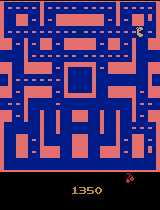

Episode finished. Total reward: 1350.0
Check 'colab_550/pacman_videos' for your recording!


In [14]:
import os
import numpy as np
import tensorflow as tf
from keras.saving import register_keras_serializable
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import time
import datetime
from IPython.display import display, clear_output
import PIL.Image

os.environ['SDL_VIDEODRIVER'] = 'dummy'

@register_keras_serializable()
class PacManDQN(tf.keras.Model):
    def __init__(self, action_size=9, **kwargs):
        super().__init__(**kwargs)
        self.action_size = action_size
        self.conv1 = tf.keras.layers.Conv2D(32, (8,8), strides=4, activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (4,4), strides=2, activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(64, (3,3), strides=1, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(512, activation='relu')
        self.output_layer = tf.keras.layers.Dense(action_size, activation='linear')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.output_layer(x)

class PacManTester:
    def __init__(self, model_path, record_video=True, video_folder="pacman_videos"):
        # Load model with custom object
        self.model = tf.keras.models.load_model(
            model_path,
            custom_objects={'PacManDQN': PacManDQN},
            compile=False
        )
        
        self.base_env = gym.make(
            "ALE/MsPacman-v5",
            render_mode="rgb_array",
            frameskip=3,
            repeat_action_probability=0.0
        )
        
        if record_video:
            os.makedirs(video_folder, exist_ok=True)
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            self.env = RecordVideo(
                self.base_env,
                video_folder=video_folder,
                name_prefix=f"pacman_{timestamp}",
                episode_trigger=lambda x: True
            )
        else:
            self.env = self.base_env
            
        self.frame_stack_size = 3

    def preprocess_frame(self, frame):
        frame = frame[1:176:2, ::2]  # Downsample to 88x80
        return np.mean(frame, axis=-1, dtype=np.float32) / 255.0

    def create_initial_state(self, frame):
        return np.stack([frame] * self.frame_stack_size, axis=-1)

    def run_episode(self, max_steps=10000, render_speed=0.03):
        try:
            frame, _ = self.env.reset()
            frame = self.preprocess_frame(frame)
            state = self.create_initial_state(frame)

            total_reward = 0
            display_handle = display(None, display_id=True)

            for _ in range(max_steps):
                q_values = self.model(np.expand_dims(state, axis=0))
                action = np.argmax(q_values.numpy()[0])

                next_frame, reward, done, _, _ = self.env.step(action)
                next_frame = self.preprocess_frame(next_frame)
                state = np.concatenate([state[..., 1:], np.expand_dims(next_frame, axis=-1)], axis=-1)
                total_reward += reward

                display_handle.update(PIL.Image.fromarray(self.env.render()))
                time.sleep(render_speed)

                if done:
                    break

            print(f"Episode finished. Total reward: {total_reward}")
            return total_reward
        
        finally:
            self.env.close()

if __name__ == "__main__":
    tester = PacManTester(
        model_path="colab_550/new_models/pacman_ep550.keras",
        record_video=True,
        video_folder="colab_550/pacman_videos"
    )
    print("Running episode...")
    reward = tester.run_episode()
    print(f"Check 'colab_550/pacman_videos' for your recording!")

## Kaggle code

In [4]:
import os
import ale_py
import gymnasium as gym
import numpy as np
import tensorflow as tf
from collections import deque
import time
from IPython.display import display, clear_output
import PIL.Image

In [18]:
class PacManDQN(tf.keras.Model):
    def __init__(self, action_size=9):
        super(PacManDQN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (8,8), strides=4, activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (4,4), strides=2, activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(64, (3,3), strides=1, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(512, activation='relu')
        self.output_layer = tf.keras.layers.Dense(action_size, activation='linear')
        self.action_size = action_size

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.output_layer(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            'action_size': self.action_size
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

def preprocess_frame(frame):
    """Must match training preprocessing exactly"""
    frame = frame[1:176:2, ::2]  # Downsample to 88x80
    return np.mean(frame, axis=-1, dtype=np.float32) / 255.0

def create_initial_state(frame, frame_stack_size=4):
    """Create initial state by repeating the first frame"""
    return np.stack([frame] * frame_stack_size, axis=-1)

def update_state(state, new_frame):
    """Update state by shifting frames and adding new frame"""
    return np.concatenate([state[..., 1:], np.expand_dims(new_frame, axis=-1)], axis=-1)

def load_model(model_path):
    """Load trained model with proper custom object handling"""
    try:
        # First try loading the entire model
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={'PacManDQN': PacManDQN},
            compile=False
        )
        print(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Standard loading failed: {e}")
        print("Attempting alternative loading method...")
        try:
            # Alternative method: create model architecture and load weights
            model = PacManDQN(action_size=9)
            # Build model with dummy input
            dummy_input = tf.random.normal((1, 88, 80, 4))
            _ = model(dummy_input)  # This builds the model
            model.load_weights(model_path)
            print("Successfully loaded weights using alternative method")
            return model
        except Exception as e:
            print(f"Failed to load model: {e}")
            raise

def test_agent(model_path, num_episodes=3, render=True, frame_skip=4, frame_stack_size=4):
    """Test the trained agent"""
    env = gym.make("ALE/MsPacman-v5",
                  render_mode="rgb_array",
                  frameskip=frame_skip,
                  repeat_action_probability=0.0)

    model = load_model(model_path)

    for episode in range(1, num_episodes + 1):
        frame, _ = env.reset()
        frame = preprocess_frame(frame)
        state = create_initial_state(frame, frame_stack_size)

        total_reward = 0
        done = False
        step = 0

        display_handle = display(None, display_id=True) if render else None

        while not done:
            # Get action from model
            q_values = model(np.expand_dims(state, axis=0))
            action = np.argmax(q_values.numpy()[0])

            # Take action
            next_frame, reward, done, _, _ = env.step(action)
            next_frame = preprocess_frame(next_frame)
            next_state = update_state(state, next_frame)

            # Render if enabled
            if render:
                current_frame = env.render()
                display_handle.update(PIL.Image.fromarray(current_frame))
                time.sleep(0.02)  # Control game speed

            total_reward += reward
            state = next_state
            step += 1

        print(f"Episode {episode}: Total Reward = {total_reward:.1f} (Steps: {step})")
        if render:
            clear_output(wait=True)

    env.close()

if __name__ == "__main__":
    # GPU Configuration
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

    # Update this path to your saved model
    MODEL_PATH = "RL models/pacman_models/pacman_ep1000.keras"  # Example path

    print("Starting Pac-Man DQN testing...")
    test_agent(
        model_path=MODEL_PATH,
        num_episodes=1,       # Test 3 episodes
        render=True,          # Set to False for faster testing
        frame_skip=4,        # Must match training frame skip
        frame_stack_size=4    # Must match training frame stack size
    )
    print("Testing completed!")

Testing completed!


- **Run & Save**

In [16]:
import os
import numpy as np
import tensorflow as tf
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import time
import datetime
from IPython.display import display, clear_output
import PIL.Image

In [17]:
class PacManDQN(tf.keras.Model):
    def __init__(self, action_size=9):
        super(PacManDQN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (8,8), strides=4, activation='relu')
        self.conv2 = tf.keras.layers.Conv2D(64, (4,4), strides=2, activation='relu')
        self.conv3 = tf.keras.layers.Conv2D(64, (3,3), strides=1, activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(512, activation='relu')
        self.output_layer = tf.keras.layers.Dense(action_size, activation='linear')
        self.action_size = action_size

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.flatten(x)
        x = self.dense(x)
        return self.output_layer(x)

    def get_config(self):
        config = super().get_config()
        config.update({
            'action_size': self.action_size
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

def preprocess_frame(frame):
    """Must match training preprocessing exactly"""
    frame = frame[1:176:2, ::2]  # Downsample to 88x80
    return np.mean(frame, axis=-1, dtype=np.float32) / 255.0

def create_initial_state(frame, frame_stack_size=4):
    """Create initial state by repeating the first frame"""
    return np.stack([frame] * frame_stack_size, axis=-1)

def update_state(state, new_frame):
    """Update state by shifting frames and adding new frame"""
    return np.concatenate([state[..., 1:], np.expand_dims(new_frame, axis=-1)], axis=-1)

def load_model(model_path):
    """Load trained model with proper custom object handling"""
    try:
        # First try loading the entire model
        model = tf.keras.models.load_model(
            model_path,
            custom_objects={'PacManDQN': PacManDQN},
            compile=False
        )
        print(f"Model loaded successfully from {model_path}")
        return model
    except Exception as e:
        print(f"Standard loading failed: {e}")
        print("Attempting alternative loading method...")
        try:
            # Alternative method: create model architecture and load weights
            model = PacManDQN(action_size=9)
            # Build model with dummy input
            dummy_input = tf.random.normal((1, 88, 80, 4))
            _ = model(dummy_input)  # This builds the model
            model.load_weights(model_path)
            print("Successfully loaded weights using alternative method")
            return model
        except Exception as e:
            print(f"Failed to load model: {e}")
            raise

def test_agent(model_path, num_episodes=3, render=True, frame_skip=4, frame_stack_size=4, record_video=False, video_folder="pacman_videos"):
    """Test the trained agent with optional video recording"""
    # Create base environment
    base_env = gym.make("ALE/MsPacman-v5",
                       render_mode="rgb_array",
                       frameskip=frame_skip,
                       repeat_action_probability=0.0)
    
    # Wrap environment for video recording if enabled
    if record_video:
        os.makedirs(video_folder, exist_ok=True)
        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        env = RecordVideo(
            base_env,
            video_folder=video_folder,
            name_prefix=f"pacman_{timestamp}",
            episode_trigger=lambda x: True  # Record every episode
        )
    else:
        env = base_env

    model = load_model(model_path)

    for episode in range(1, num_episodes + 1):
        frame, _ = env.reset()
        frame = preprocess_frame(frame)
        state = create_initial_state(frame, frame_stack_size)

        total_reward = 0
        done = False
        step = 0

        display_handle = display(None, display_id=True) if render else None

        while not done:
            # Get action from model
            q_values = model(np.expand_dims(state, axis=0))
            action = np.argmax(q_values.numpy()[0])

            # Take action
            next_frame, reward, done, _, _ = env.step(action)
            next_frame = preprocess_frame(next_frame)
            next_state = update_state(state, next_frame)

            # Render if enabled
            if render:
                current_frame = env.render()
                display_handle.update(PIL.Image.fromarray(current_frame))
                time.sleep(0.03)  # Control game speed

            total_reward += reward
            state = next_state
            step += 1

        print(f"Episode {episode}: Total Reward = {total_reward:.1f} (Steps: {step})")
        if render:
            clear_output(wait=True)

    env.close()
    if record_video:
        print(f"Videos saved to: {os.path.abspath(video_folder)}")

if __name__ == "__main__":
    # GPU Configuration
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

    # Configuration
    MODEL_PATH = "RL models/pacman_models/pacman_ep1000.keras"
    VIDEO_FOLDER = "RL models/pacman_test_videos"
    
    print("Starting Pac-Man DQN testing...")
    test_agent(
        model_path=MODEL_PATH,
        num_episodes=1,           # Test 3 episodes
        render=True,              # Set to False for faster testing
        frame_skip=4,             # Must match training frame skip
        frame_stack_size=4,       # Must match training frame stack size
        record_video=True,        # Enable video recording
        video_folder=VIDEO_FOLDER # Custom video folder
    )
    print("Testing completed!")

Videos saved to: d:\RL\RL models\pacman_test_videos
Testing completed!
